In [228]:
import integration.rhs as rhs
import integration.gauss_legendre as gl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.special as sp
import FourierSeries as fs
from scipy.integrate import solve_ivp

In [12]:
simManager = rhs.SimulationManager(r"D:\repos\superfluid-dynamics\CuSuperHelium\x64\Release\CuSuperHelium.dll")

In [ ]:
alpha_hammaker = 2.6e-24


N = 512//2
def rhs_func(t, y, L = 1e-6, depth = 15e-9):
        local_x = y[:N]
        local_ampl = y[N:2*N]
        local_pot = y[2*N:3*N]
        res, vx, vy, dphi = simManager.calculate_rhs_from_vectors(local_x, local_ampl, local_pot, L, 145, 0, depth)
        if res != 0:
            raise Exception("Error in calculation")
        return np.concatenate((vx, vy, dphi))

def mode(t, r, r0, R, omega, zeta, A, phase_space=0, phase_time=0):
        return A * np.cos(zeta * (r - r0) / R + phase_space) * np.cos(omega * t + phase_time)
def zeta(n):
        return sp.jn_zeros(1, n)
modes = 1
zetas = zeta(modes)
def c3(d):
        return np.sqrt(3 * alpha_hammaker / d**3)
def angular_freq(zeta, _c3, R):
    return zeta * _c3 / R

L = 500e-3
depth = 15e-9

def f(y):
    return rhs_func(0, y, L, depth)

def J(y):
    local_x = y[:N]
    local_ampl = y[N:2*N]
    local_pot = y[2*N:3*N]
    res, jacobian = simManager.calculate_jacobian(local_x, local_ampl, local_pot, L, 145, 0, depth)
    if jacobian is None or res != 0:
        raise Exception("Error in Jacobian calculation")
    return jacobian

r = np.array([2.0*np.pi/N*x for x in range(N)])
initial_amplitude = 0.1*depth
L0 = L / (2.0 * np.pi)
g = 3*2.6e-24 / depth**4
_t0 = np.sqrt(L0 / g)

speed = c3(depth)
omegas = angular_freq(zetas, speed, 2*np.pi)
phase_spaces = np.zeros_like(zetas)  # np.random.uniform(0, 0.1*np.pi, modes)

def gaussian(x, x0 = 0.75*np.pi, sigma=0.4):
        return np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))
def soliton_sech2(x, x0 = 0.75*np.pi, width=0.4):
        return 1.0 / np.cosh((x - x0) / width) ** 2

def bimodal(x, x0, x1, sigma1 = 0.4, sigma2 = 0.4, a1 = 1.0, a2 = 1.0):
    return a1 * gaussian(x, x0, sigma1) + a2 * soliton_sech2(x, x1, sigma2)



amplitude = []
potential = []
for i in range(modes):
    m = lambda x: mode(0, x, np.pi, 2.0*np.pi, omegas[i], zetas[i], initial_amplitude / L0, 0, phase_spaces[i])
    a0_ex, an_ex, bn_ex = fs.compute_fourier_series(lambda x: soliton_sech2(x, np.pi, 0.5), 12) # fs.compute_fourier_series(lambda x: bimodal(x, 0.2*np.pi, 0.7*np.pi, 0.15, 0.15, initial_amplitude / L0, initial_amplitude / L0), 10)
    m_ampl = [fs.fourier_series(x, a0_ex, an_ex, bn_ex) for x in r]
    amplitude.append(m_ampl)
    # amplitude.append(np.cos((i + 1) * r) * initial_amplitude / L0)
    # potential.append(np.sin((i + 1) * r) * initial_amplitude / L0)

sum = np.sum(amplitude, axis=0)
ampl = sum / np.max(np.abs(sum)) * (initial_amplitude / L0)

# pot = np.sum(potential, axis=0)
# pot = pot / np.max(np.abs(pot)) * (initial_amplitude / L0)
pot = np.zeros_like(r)
# ampl = np.cos(r) * initial_amplitude / L0
# pot = initial_amplitude/L0 *  # * np.sin(r)

y0 = np.concatenate((r, ampl, pot))

print(f"Reference Time is {_t0:.2e} s")

t0 = 0.0
t1 = 500
h = 3
print(f"Integrating from t={t0:.2e} to t={t1:.3f} (nondim) with step h={h} (nondim))")

Reference Time is 2.27e-05 s
Integrating from t=0.00e+00 to t=500.000 (nondim) with step h=3 (nondim))


In [364]:
plt.figure()
plt.plot(r, ampl, label="Initial Amplitude")

In [360]:
res, Jac = simManager.calculate_jacobian(r, ampl, pot, L, 145, 0, depth)
eigvals = np.linalg.eigvals(Jac)
plt.figure()
plt.scatter(np.real(eigvals), np.imag(eigvals), label="Eigenvalues of Jacobian")

In [365]:
# t0, t1, h = 0.0, 547, 0.5
T, Y = gl.integrate_gl2(f, J, y0, t0, 25*t1, 10, simplified=False, newton_maxit = 60, newton_tol = 1e-7)

# result = solve_ivp(lambda t, y: f(y), (t0, t1), y0, method='RK45')

Integrating: 100%|██████████| 1250/1250 [08:02<00:00,  2.59step/s]


In [ ]:
plt.figure()
# plt.plot(r, result.y[N:2*N, -1], label="Final Amplitude")

In [366]:
r0 = r[N//2+10]
plt.figure()
plt.plot(T, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

Text(0.5, 1.0, 'Amplitude at a fixed position over time - 1 modes')

In [57]:
T1, Y1 = gl.integrate_gl2(f, J, Y[-1, :], t0, t1, 5, simplified=False, newton_maxit = 60, newton_tol = 1e-11)

Integrating: 100%|██████████| 100/100 [08:55<00:00,  5.35s/step]


In [58]:
r0 = r[N//2+10]
plt.figure()
plt.plot(T1, Y1[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

Text(0.5, 1.0, 'Amplitude at a fixed position over time - 1 modes')

In [128]:
with h5py.File("simulation_gaussian_highampl0.1.h5", "w") as file:
    file.create_dataset("T", data=T)
    file.create_dataset("Y", data=Y)
    file.create_dataset("x0", data=r)
    file.create_dataset("y0", data=ampl)
    file.create_dataset("pot0", data=pot)

In [50]:
%matplotlib Qt

In [327]:
from scipy.interpolate import interp1d

def extrapolate(x, y, x0):
    f = interp1d(x, y, fill_value="extrapolate")
    return f(x0)

amplitudes = []
x = np.linspace(0, 2*np.pi, 2*N)
for i in range(len(T)):
    t = T[i]
    val = extrapolate(Y[i, :N], Y[i, N:2*N], x)
    amplitudes.append(val)
amplitudes = np.array(amplitudes)

X, TT = np.meshgrid(x, T)

# 3D surface plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(TT, X, amplitudes, cmap='viridis', linewidth=0, antialiased=True)

ax.set_xlabel('Time')
ax.set_ylabel('x')
ax.set_zlabel('Amplitude')
ax.set_title('Amplitude evolution over time and space')

fig.colorbar(surf, shrink=0.5, aspect=10, label='Amplitude')
# plt.show()


print(amplitudes[0].shape)
plt.figure(figsize=(10,6))
plt.contourf(T, x, amplitudes.T, levels=100, cmap='viridis')
# plt.plot(T, amplitudes, label=f"Amplitude at r={2*np.pi - 0.2:.2f} L")
plt.xlabel("Time (dimensionless)")
plt.ylabel("x (dimensionless)")
plt.title(f"Amplitude evolution over time and space - {modes} modes")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(512,)


In [238]:
plt.figure()
plt.plot(T, amplitudes[:, 32], label=f"Amplitude at r={x[32]:.2f}")
plt.xlabel("Time (dimensionless)")
plt.ylabel("Amplitude (dimensionless)")
plt.legend()
plt.title(f"Amplitude at a fixed position over time - {modes} modes")

Text(0.5, 1.0, 'Amplitude at a fixed position over time - 1 modes')

100%|██████████| 1095/1095 [00:41<00:00, 26.10it/s]


ValueError: x and y must have same first dimension, but have shapes (55,) and (1095,)

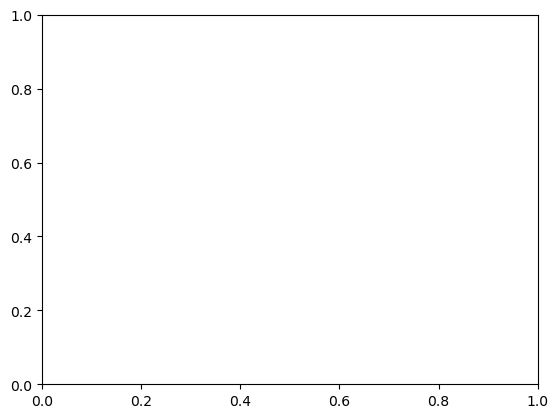

In [ ]:
import tqdm


t = 11
max_real_pos = []
for t in tqdm.tqdm(range(T.shape[0])):
    res, J = simManager.calculate_jacobian(Y[t, :N], Y[t, N:2*N], Y[t, 2*N:3*N], L, 145, 0, depth)
    eigvals = np.linalg.eigvals(J)
    max_real_pos.append(np.max(eigvals.real))

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")

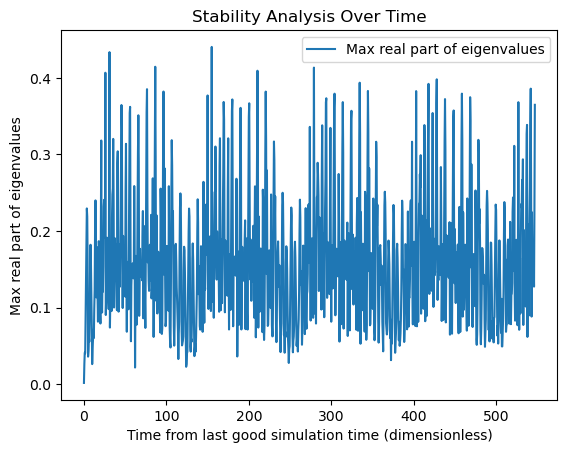

In [10]:

plt.plot(T, max_real_pos, label="Max real part of eigenvalues")
plt.xlabel("Time from last good simulation time (dimensionless)")
plt.ylabel("Max real part of eigenvalues")
plt.legend()
plt.title("Stability Analysis Over Time")
plt.show()

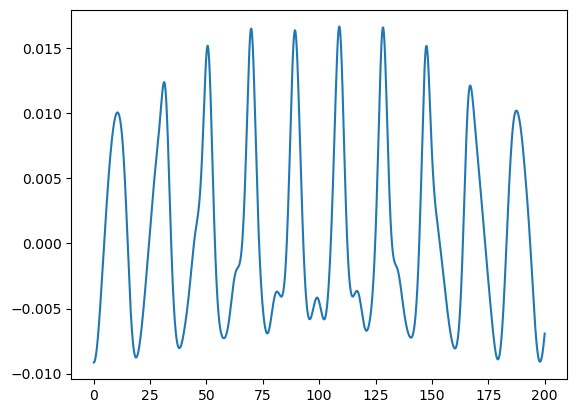

In [18]:
plt.plot(T, Y[:, N+ N//2+10], label=f"Amplitude at r={r0:.2e} m")

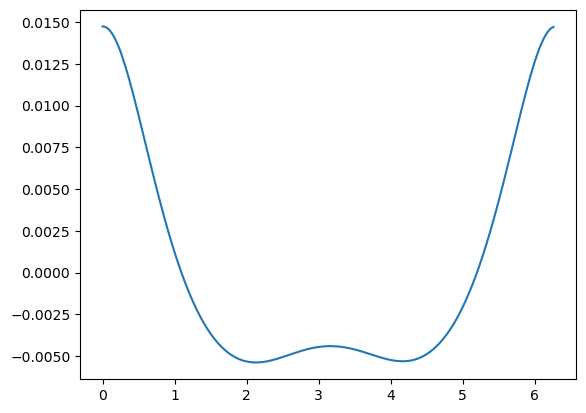

In [17]:
plt.plot(r, Y[1250, N:2*N], label="Initial amplitude")

In [3]:
with h5py.File("simulation.h5", "r") as file:
    T = file["T"][:]
    Y = file["Y"][:]
    

In [53]:
%matplotlib Qt

In [369]:
from matplotlib.animation import FuncAnimation
N = 128*2
fig, ax = plt.subplots()

line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(Y[0, 0], Y[0, N-1])
    ax.set_ylim(Y[:, N:2*N].min(), Y[:, N:2*N].max())
    return line,

def update(frame):
    line.set_data(Y[frame, :N], Y[frame, N:2*N])
    return line,

ani = FuncAnimation(fig, update, frames=len(T), init_func=init, blit=True)
plt.show()